# Neural & Behavioral Modeling - Week 14 (Examples)
by Tsung-Ren (Tren) Huang (trhuang@g.ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
import random
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import sympy as sym
from IPython.display import HTML

## 1 1D Spiking Neurons

### 1.1 Leaky Integrate-and-Fire Model

<img src="https://www.researchgate.net/profile/Johnny_Ottesen/publication/259354305/figure/fig15/AS:341832178389010@1458510550314/Diagram-for-leaky-integrate-and-fire-model-The-circuit-diagram-left-represents-the.png" width=60%>

Some (bad) implementations have resets but not spikes, such as https://github.com/suzusuzu/neuron-model:

<img src="https://github.com/suzusuzu/neuron-model/blob/master/img/if.png?raw=true" width=60%>

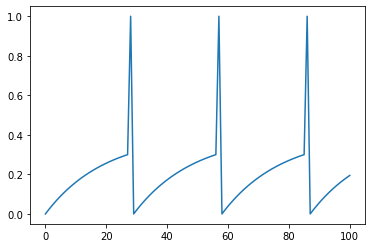

In [2]:
I=2;g=5;C=10;Vrst=0;Vthr=.3;Vspk=1;

dt=.1; V=[Vrst];
for t in np.arange(0,10,dt):
        V1=V[-1] # the last element
    s=V1>Vthr; # An implicit IF-THEN hack
    V2=s*Vrst+(1-s)*(V1+dt/C*(-g*V1+I)) # Euler integration
    V1=s*Vspk+(1-s)*V1 # Spiking now?
    V[-1]=V1; V.append(V2)

plot(V);

## 2 4D Spiking Models

In the integrate-and-fire model, the spiking is generated manually. Ideally, the spikes should be generated automatically by the system dynamics:

<img src="https://royalsocietypublishing.org/cms/asset/2a4d1c15-68ed-4d0d-a083-1f211720703e/rsta20100130f01.jpg" width=75%>

In [3]:
HTML("https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model#Voltage-gated_ion_channels")

### 2.0 Some analytical derivations

In [4]:
a,b,t=sym.symbols('a,b,t')
n=sym.Function('n')(t)
sym.dsolve(n.diff()-a*(1-n)+b*n) # solving dn/dt=a*(1-n)-b*n

Eq(n(t), (a + exp((C1 - t)*(a + b)))/(a + b))

### 2.1 Hodgkin–Huxley Model

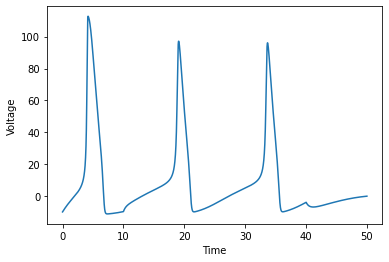

In [6]:
# Integration of Hodgkin--Huxley equations with Euler method
g=np.array([36, 120, 0.3]) # Maximal conductances (in units of mS/cm^2); 1=K, 2=Na, 3=l
E=np.array([-12, 115, 10.613]) # Resting potentials (in mV):
# Some initializations: some variables
gnmh=np.zeros(3); Alpha=np.zeros(3); Beta=np.zeros(3); x=np.zeros(3); 
x[2]=1; I_ext=0; V=[-10]; dt=0.01; 

tspan=np.arange(0,50,dt)
for t in tspan:
    
    V1=V[-1] # the last element
    if(t>=10 and t<=40):
        I_ext=10  # turns external current on when t=[10,40]
    else:  
        I_ext=0   
        
  # alpha functions:
    Alpha[0]=0.01*(10-V1)/(np.exp((10-V1)/10)-1)
    Alpha[1]=0.1*(25-V1)/(np.exp((25-V1)/10)-1)
    Alpha[2]=0.07*np.exp(-V1/20)
    
  # beta functions:
    Beta[0]=0.125*np.exp(-V1/80)
    Beta[1]=4*np.exp(-V1/18)
    Beta[2]=1/(np.exp((30-V1)/10)+1)
    
  # tau_x and x_0 (x=0,1,2) are defined with alpha and beta
    tau=1/(Alpha+Beta);
    x_inf=Alpha*tau;
    x=x+dt*(x_inf-x)/tau;
    
  # calculate actual conductances g with given n, m, h
    gnmh[0]=g[0]*x[0]**4;
    gnmh[1]=g[1]*x[1]**3*x[2];
    gnmh[2]=g[2];
    
  # Ohm's law
    I=gnmh*(V1-E);
    V2=V1+dt*(I_ext-sum(I))
    V.append(V2)
    
plot(tspan,V[:-1]); 
xlabel('Time'); ylabel('Voltage');

## 3 2D Spiking Models

### 3.1 Izhikevich Neurons

<img src="https://www.izhikevich.org/publications/izhik.gif" width=75%>

Izhikevich provides his Matlab <a href="https://www.izhikevich.org/publications/figure1.m">source code</a> to produce the above figure.

In [7]:
def Izhikevich(a,b,c,d,V,Iext,tau,T2):
    u=b*V; VV=[]; uu=[];
    tspan=np.arange(0,T2,tau)
    T1=tspan[-1]/10
    for t in tspan:
        I=Iext if t>T1 else 0
        V = V + tau*(0.04*V**2+5*V+140-u+I)
        u = u + tau*a*(b*V-u)
        if V > 30:
            VV.append(30)
            V=c
            u=u+d
        else:
            VV.append(V)
        uu.append(u)
    return tspan,VV 

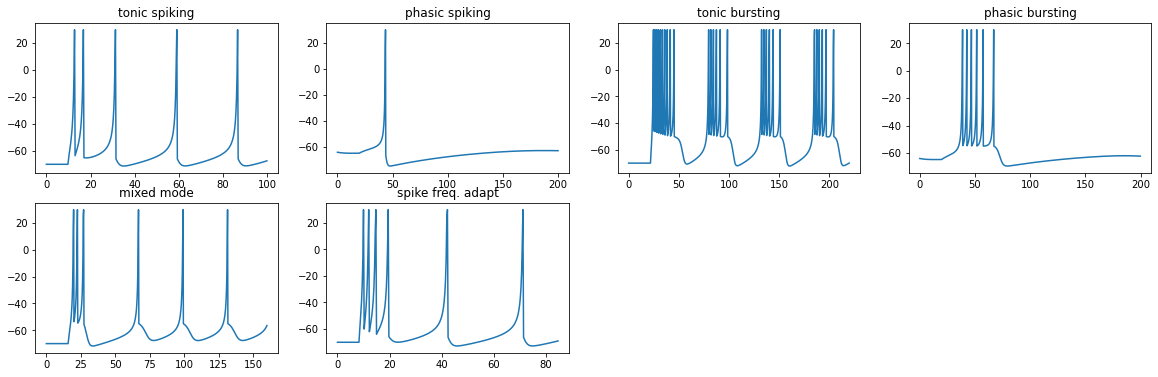

In [8]:
figure(figsize=(20,16))
subplot(5,4,1)
tspan,VV=Izhikevich(0.02,0.2,-65,6,-70,14,0.25,100)
plot(tspan,VV); title('tonic spiking');
subplot(5,4,2)
tspan,VV=Izhikevich(0.02,0.25,-65,6,-64,0.5,0.25,200)
plot(tspan,VV); title('phasic spiking');
subplot(5,4,3)
tspan,VV=Izhikevich(0.02,0.2,-50,2,-70,15,0.25,220)
plot(tspan,VV); title('tonic bursting');
subplot(5,4,4)
tspan,VV=Izhikevich(0.02,0.25,-55,0.05,-64,0.6,0.2,200)
plot(tspan,VV); title('phasic bursting');
subplot(5,4,5)
tspan,VV=Izhikevich(0.02,0.2,-55,4,-70,10,0.25,160)
plot(tspan,VV); title('mixed mode');
subplot(5,4,6)
tspan,VV=Izhikevich(0.01,0.2,-65,8,-70,30,0.25,85)
plot(tspan,VV); title('spike freq. adapt');

### 3.2  AdEx Neuron
The model is described in <a href="http://jn.physiology.org/content/jn/94/5/3637.full.pdf">this article</a>:
<img src="http://www.digicortex.net/img/adex.png">

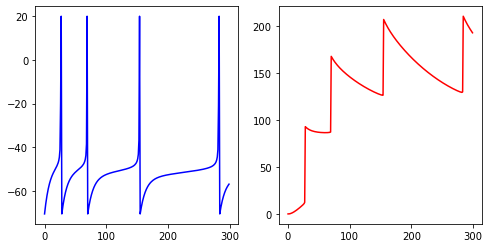

In [9]:
C=281; gL=30; VT=-50.4; DeltaT=2;
tauW=144; a=4; b=80.5; EL=-70.6; # Regular spiking 
#tauW=20; a=4; b=500; EL=-45.4; #Bursting
#tauW=144; a=3.9; b=0; EL=-70.6; #Fast spiking
V=[EL]; u=[0]; dt=1; I=700; #pA

tspan=np.arange(0,300,dt)
for t in tspan:
    V1=V[-1]; u1=u[-1];
    if(V1>20):
        V[-1]=20
        V2=EL
        u2=u2+b
    else:
        V2=V1+dt*(-gL*(V1-EL)+gL*DeltaT*np.exp((V1-VT)/DeltaT)-u1+I)/C;
        u2=u1+dt*(a*(V1-EL)-u1)/tauW;
    V.append(V2)
    u.append(u2)
    
figure(figsize=(8,4))
subplot(1,2,1);plot(tspan,V[:-1],'b')
subplot(1,2,2);plot(tspan,u[:-1],'r');